<a href="https://colab.research.google.com/github/Sunnnyyy16/EmoSupportAI/blob/sunny/user_input_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# User's input emotion visualization
* 사용자 인풋 시각화
  * 1) Top4 piechart
  * 2) 문장별 감정 점수(-1: 부정, 0: 중립, 1: 긍정) line plot 시각화
* huggingface transformer library, ntlk 활용
* MH-llama visual, SupportlyChat에 사용됨

# library import

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize
import nltk

nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# text 준비

In [ ]:
# input_text에 시각화 하고자하는 텍스트 입력

input_text = """These days, it’s so hard to focus on studying.
I’m juggling writing a thesis, studying for school classes, doing class assignments, working on two projects, and attending special lectures all at the same time.
There’s so much to do, but I keep procrastinating.
I usually end up handling everything right before the deadline, even if it means getting very little sleep, but it’s really taking a toll on me physically.
I know it’s better to get things done ahead of time, but it’s so hard to put that into practice, and sometimes I feel a sense of self-doubt because of it.
On top of that, my research isn’t progressing well, and I worry about whether I’ll be able to complete my master’s program successfully.
Will I really be able to graduate?"""

# 1. Emotion 분류& 시각화: Piechart
* "SamLowe/roberta-base-go_emotions" 의 28개 multi-label classification 모델 사용
* top 4개 감정 예측하여 pie chart로 시각화

In [ ]:
# 28개 감정 라벨 중에 Top 4 감정만 예측
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=4)

sentences = [input_text]

model_outputs = classifier(sentences)
model_outputs[0]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'disappointment', 'score': 0.33904191851615906},
 {'label': 'nervousness', 'score': 0.26055964827537537},
 {'label': 'sadness', 'score': 0.1704655885696411},
 {'label': 'confusion', 'score': 0.14241106808185577}]

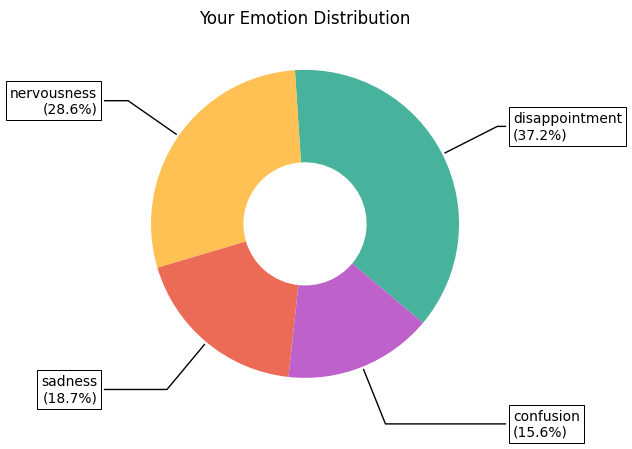

In [ ]:
# 감정 점수 딕셔너리 생성
all_emotion_scores = {emotion['label']: emotion['score'] for emotion in model_outputs[0]}

# 파이차트 컬러팔레트
colors = ['#47B39C','#FFC154', '#EC6B56','#BE61CA']

### 파이차트 그리기!
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))

emotion_labels = list(all_emotion_scores.keys())
emotion_values = list(all_emotion_scores.values())

wedges, texts = ax.pie(emotion_values,
                       wedgeprops=dict(width=0.6),
                       startangle=-40,
                       colors=colors)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))

    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})

    # 각 감정이 총합에서 몇 퍼센트 차지하는지 계산해서 annotation에 추가
    percentage = (emotion_values[i] / sum(emotion_values)) * 100
    annotation_text = f"{emotion_labels[i]}\n({percentage:.1f}%)"

    ax.annotate(annotation_text, xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Your Emotion Distribution")
plt.show()


# 2. 문장별 감정 점수 시각화
* nltk 라이브러리 사용해서 문단에서 문장 나누기
* "finiteautomata/bertweet-base-sentiment-analysis"를 이용해 각 문장별 감정 점수(-1~1) 측정.
* 감정 점수는 음수 부정적, 양수는 긍정적 감정을 뜻하며 점수절대값이 클수록 감정 정도가 큼을 뜻함

config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Sentence 1:  These days, it’s so hard to focus on studying. , sentiment score:  -0.9635656476020813
Sentence 2:  I’m juggling writing a thesis, studying for school classes, doing class assignments, working on two projects, and attending special lectures all at the same time. , sentiment score:  -0.7970614433288574
Sentence 3:  There’s so much to do, but I keep procrastinating. , sentiment score:  -0.8770259618759155
Sentence 4:  I usually end up handling everything right before the deadline, even if it means getting very little sleep, but it’s really taking a toll on me physically. , sentiment score:  -0.7115285992622375
Sentence 5:  I know it’s better to get things done ahead of time, but it’s so hard to put that into practice, and sometimes I feel a sense of self-doubt because of it. , sentiment score:  -0.9170974493026733
Sentence 6:  On top of that, my research isn’t progressing well, and I worry about whether I’ll be able to complete my master’s program successfully. , sentiment s

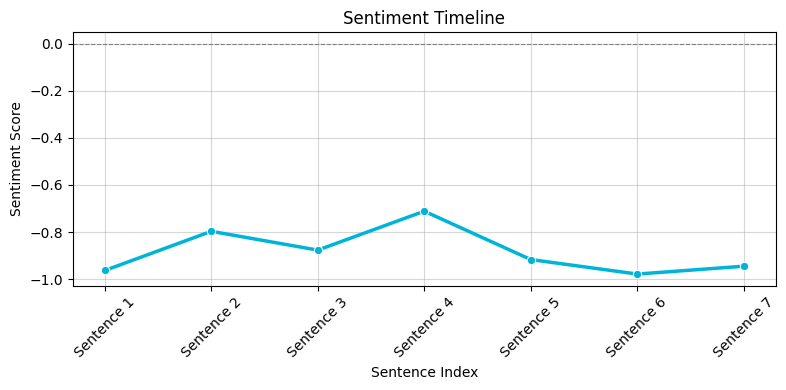

In [ ]:
# input_text 문장별로 나누기
sentences = sent_tokenize(input_text)

# 허깅페이스에서 bert기반 sentiment analysis pipeline
sentiment_analyzer = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")

# 문장별 sentiment score -> -1: 부정, 0: 중립, 1: 긍정
sentiment_scores = []
for i in range(len(sentences)):
  result = sentiment_analyzer(sentences[i])[0]
  score = result["score"] if result["label"] == "POSITIVE" else -result["score"]
  print(f"Sentence {i+1}: ", sentences[i], ", sentiment score: ", score)
  sentiment_scores.append(score)

# plot
plt.figure(figsize=(8, 4))
sns.lineplot(
    x=range(len(sentences)),
    y=sentiment_scores,
    marker="o",
    color="#00b4d8",
    linewidth=2.5
)
plt.title("Sentiment Timeline")
plt.xlabel("Sentence Index")
plt.ylabel("Sentiment Score")
plt.xticks(range(len(sentences)), [f"Sentence {i+1}" for i in range(len(sentences))], rotation=45, fontsize=10)
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()